# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка необходимых библиотек

In [1]:
!pip install lightgbm
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import re
import torch
import transformers
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

from tqdm import tqdm, notebook

from wordcloud import WordCloud

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

tqdm.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
try:
    df = pd.read_csv('F:\\project\\comment_project\\toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

### Загрузка данных и их предобработка

In [5]:
df.sample(10)

,text,toxic
6324,Just a side not did YOU notice that of all the...,0
66358,"""\n\nFirst, the dust cover is not a part of th...",0
114587,"Vegan rebuttal \n\nHello,\n\nI have been follo...",0
90301,"Hi Thank your mery much for your reply, and p...",0
59512,Which one has a more distinct taste?,0
82697,""" I'm only trying to be semi-awkward here, I a...",0
151204,I'm not saying that he is or is not using ster...,0
32011,"Hi, I sent you a rather gentle warning on the ...",0
99307,"Dear editors...\nJust to make things clear, Wi...",0
131827,Semi-protected edit request on 16 February 201...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Удаляем из набора данных лишний столбец, который дублирует индексы

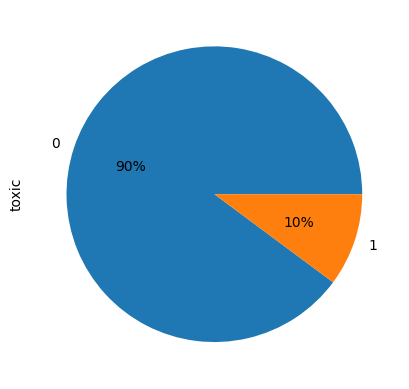

In [7]:
df['toxic'].value_counts().plot(kind='pie', autopct='%1.0f%%');

Из целевого признака мы видим, что преобладает количество нетоксичных комментариев, что говорит нам о дисбалансе данных.

In [8]:
df['text'] = df['text'].str.lower()

Делаем все символы строчными.

### Очищаем текст

In [9]:
clearn_text = []
pattern = r'[^a-zA-Z0-9]'
for i in df.text:
  clearn = re.sub(pattern, ' ', i)
  clearn_text.append(' '.join(clearn.split()))

In [10]:
df['clearn'] = clearn_text
df.head()

,text,toxic,clearn
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


Убрали из текста все лишние символы и оставили только буквы и цифры

### Лемматизируем текс

In [12]:
wnl = WordNetLemmatizer()

In [13]:
tokenizer = df['clearn'].progress_apply(
    lambda x: nltk.word_tokenize(x, language='english'))

100%|██████████| 159292/159292 [01:55<00:00, 1374.55it/s]


In [14]:
tokenizer

0         [explanation, why, the, edits, made, under, my...
1         [d, aww, he, matches, this, background, colour...
2         [hey, man, i, m, really, not, trying, to, edit...
3         [more, i, can, t, make, any, real, suggestions...
4         [you, sir, are, my, hero, any, chance, you, re...
                                ...                        
159446    [and, for, the, second, time, of, asking, when...
159447    [you, should, be, ashamed, of, yourself, that,...
159448    [spitzer, umm, theres, no, actual, article, fo...
159449    [and, it, looks, like, it, was, actually, you,...
159450    [and, i, really, don, t, think, you, understan...
Name: clearn, Length: 159292, dtype: object

Разбиваем текст на слова, для дальнейщей лемматизации.

In [15]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

Пишем функцию, которая определяет, какое слово перед нами и помечает их POS тегами

In [16]:
stopwords = set(stopwords.words('english'))

In [17]:
lemm = tokenizer.progress_apply(
    lambda x: [' '.join(wnl.lemmatize(w, get_wordnet_pos(w)) for w in x if not w in stopwords)])
lemm

100%|██████████| 159292/159292 [2:26:56<00:00, 18.07it/s]  


0         [explanation edits make username hardcore meta...
1         [aww match background colour seemingly stuck t...
2         [hey man really try edit war guy constantly re...
3         [make real suggestion improvement wonder secti...
4                           [sir hero chance remember page]
                                ...                        
159446    [second time ask view completely contradicts c...
159447    [ashamed horrible thing put talk page 128 61 1...
159448    [spitzer umm there actual article prostitution...
159449    [look like actually put speedy first version d...
159450    [really think understand come idea bad right a...
Name: clearn, Length: 159292, dtype: object

In [18]:
df['lemm'] = pd.DataFrame(lemm, index=df.index)
df.head()

,text,toxic,clearn,lemm
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,[explanation edits make username hardcore meta...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,[aww match background colour seemingly stuck t...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,[hey man really try edit war guy constantly re...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,[make real suggestion improvement wonder secti...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,[sir hero chance remember page]


Переводим слова в начальную форму. Так же из текста удаляем стоп слова, которые негативно отразятся на предсказаниях модели

In [19]:
text_raw = lemm.progress_apply(lambda x: " ".join(x))
text_raw = " ".join(text_raw)

100%|██████████| 159292/159292 [00:01<00:00, 144416.93it/s]


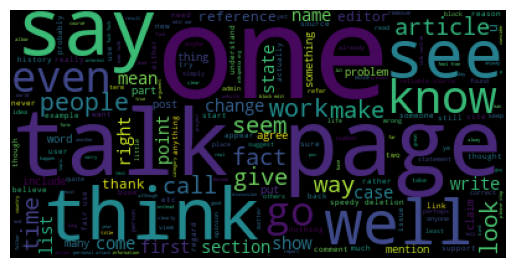

In [20]:
wordcloud = WordCloud().generate(text_raw)

plt.imshow(wordcloud)
plt.axis('off');

Построив облако слов мы видем самые популярные слова

### Векторизация текста

In [77]:
X = lemm.progress_apply(lambda x: " ".join(x))
y = df['toxic']

100%|██████████| 159292/159292 [00:00<00:00, 197638.49it/s]


In [78]:
X

0         explanation edits make username hardcore metal...
1         aww match background colour seemingly stuck th...
2         hey man really try edit war guy constantly rem...
3         make real suggestion improvement wonder sectio...
4                             sir hero chance remember page
                                ...                        
159446    second time ask view completely contradicts co...
159447    ashamed horrible thing put talk page 128 61 19 93
159448    spitzer umm there actual article prostitution ...
159449    look like actually put speedy first version de...
159450    really think understand come idea bad right aw...
Name: clearn, Length: 159292, dtype: object

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=12345)

In [80]:
print('Размер тренировочной выборки:', len(X_train), y_train.shape)
print('Размер тестовой выборки:', len(X_test), y_test.shape)

Размер тренировочной выборки: 119469 (119469,)
Размер тестовой выборки: 39823 (39823,)


Разбиваем данные на 2 части, одну делаем тренировочной, другую тестовой, на которой будем проверять модель

In [81]:
count_tf_idf = TfidfVectorizer()
X_train = count_tf_idf.fit_transform(X_train)

In [82]:
X_test = count_tf_idf.transform(X_test)

Векторизируем данные методом Tf_idf.

## Обучение

In [83]:
f1 = make_scorer(f1_score)

### Модель логистической регрессии

In [84]:
parametrs_lr = {'lr__C': range (2, 10, 2),
               'lr__max_iter': range (50, 200, 50)}

In [85]:
pipeline_lr = Pipeline([('lr', LogisticRegression(class_weight="balanced", random_state=12345))])

In [86]:
grid_lr = GridSearchCV(pipeline_lr, param_grid = parametrs_lr, n_jobs=-1, scoring=f1, cv=2)
grid_lr.fit(X_train, y_train)

C:\Users\grace\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=12345))]),
             n_jobs=-1,
             param_grid={'lr__C': range(2, 10, 2),
                         'lr__max_iter': range(50, 200, 50)},
             scoring=make_scorer(f1_score))

In [87]:
print('Лучшие параметры:', grid_lr.best_params_)
print('Лучший f1:', grid_lr.best_score_)

Лучшие параметры: {'lr__C': 8, 'lr__max_iter': 50}
Лучший f1: 0.7606620413332742


### Модель ЛГБМ

In [98]:
parametrs_lgbm = {'n_estimators': range(50, 200, 50),
            'max_depth': range(1, 16, 4)}

In [99]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=12345)
grid_lgbm = GridSearchCV(lgbm, param_grid = parametrs_lgbm, n_jobs=-1, scoring = f1, cv=2)
grid_lgbm.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=LGBMClassifier(class_weight='balanced',
                                      random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 16, 4),
                         'n_estimators': range(50, 200, 50)},
             scoring=make_scorer(f1_score))

In [100]:
print('Лучшие параметры ЛГБМ:', grid_lgbm.best_params_)
print('Лучший f1 ЛГБМ:', grid_lgbm.best_score_)

Лучшие параметры ЛГБМ: {'max_depth': 13, 'n_estimators': 150}
Лучший f1 ЛГБМ: 0.7492087154365801


### Тестируем лучшую модель

In [101]:
lr_test = grid_lr.best_estimator_
predict_test = lr_test.predict(X_test)
print('Показатель f1 на тесте:', f1_score(y_test, predict_test))

Показатель f1 на тесте: 0.7682676986114273


Наилучший результат дала модель линейной регрессии. Ее показатель f1 на тестовой равен 71

## Bert

In [102]:
#corpus_bert = df.sample(n=2000).reset_index(drop=True)
X, X_bert, y, y_bert = \
train_test_split(df['text'], df['toxic'], test_size=.012, stratify=df['toxic'], random_state=12345)

In [103]:
print(X.shape)
print(X_bert.shape)

(157380,)
(1912,)


In [105]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
tokenized = X_bert.apply(
  lambda x: tokenizer.encode(x[:512], add_special_tokens=True))

In [108]:
padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

In [109]:
attention_mask = np.where(padded != 0, 1, 0)

In [110]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/19 [00:00<?, ?it/s]

In [120]:
features = np.concatenate(embeddings)
y_bert = y_bert[:1900]
print(features.shape, y_bert.shape)

(1900, 768) (1900,)


In [121]:
X_train, X_test, y_train, y_test = \
train_test_split(features, y_bert, test_size=.25, stratify=y_bert, random_state=12345)

In [124]:
lr_bert = LogisticRegression(class_weight='balanced', max_iter=200, random_state=12345)

In [125]:
lr_bert.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=12345)

In [126]:
predict_bert = lr_bert.predict(X_test)

In [127]:
print('Показатель f1 модели Bert:', f1_score(y_test, predict_bert))

Показатель f1 модели Bert: 0.9292929292929293


При тестировании модели, текстами обработаными нейроной сетью Bert, результат f1 равен 0.92. Но данный ресурс энергоемкий и требует больших вычеслительных данных. При работе было решено использовать Toxic-Bert, так как она максимально подходит под нашу задачу.

## Выводы

**В ходе исследования**

1. Загрузили все данные, проверили их
2. Очистили все данные от лишних символов
3. Очистили текст от стоп слов
4. Перевели все слова в начальную форму
5. Обучили 4 модели и нашли из них лучшую
6. Провели исследование с помощью нейроной сети Bert

**Из исследования получены результаты:**

1. Из данных удалили лишний столбец, который дублировал индексы. Так же все данные мы перевели в нижний регистр
2. Из текстов мы убрали все лишние символы. Оставили только буквы и цифры.
3. Перевели все слова в начальную форму. Это необходимо для дальнейшей обработки данных и перевода их в вектор.
4. Из текста убрали стоп слова, оставили только основные слова, по которым и будет предсказывать модель.
5. Перевели текста в вектора, для этого использовали модель TF_IDF. Это необходимо для дальнейшего обучения моделей и предсказаний.
6. Обучили 4 модели:
- Линейную регрессию. Данная модель показала лучшие показатели f1 для текстов. Показатель равен 0.76.
- Модель леса дала наихудщий результат. Модель с параметрами леса 20 и глубиной 9, дала всего лишь 0.65
- Модель кота дала второй результат. Лучшие параметры модели итерации 50 и глубина 7 дала результат 0.75
- Модель ЛГБМ отстала на совсем немного от модели кота. Ее показатель f1 равен 0.74 при глубине 1 и количество итераций 150
7. Протестировали лучшую модель. Ее показатели f1 равны 0.76
8. Подготовили и проверили данные на модели линейной регрессии, нейросетью Bert. Исследование проходило на небольшой выборке данных, так как нейросеть требовательна к техническим данным компьютера. Модель Работает и дает предсказания. Данную модель можно переносить на более мощное оборудование и делать просчеты.

**Общие рекомендации**

При наличии мощного оборудования, можно прогнать весь текст через модель Bert. Она дала наилучший вариант на маленькой выборке, что может говорить о том, что на всей выборке она даст наилучший результат. Но минус данной модели является время и необходимые мощности. В нашем проекте модель подготовлена и готова к использованию в дальнейщем на больших объемах данных.